# Predicción de Cancelación de Clientes (Churn)

## Introducción
Este proyecto busca anticiparse al problema de la cancelación de clientes. Para ello vamos a desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios. 

### Vamos a desarrollar: 
- Prepararación de los datos para el modelado (tratamiento, codificación, normalización).
- Realización del análisis de correlación y selección de variables.
- Entrenar dos o más modelos de clasificación.
- Evaluar el rendimiento de los modelos con métricas.
- Interpretar los resultados, incluyendo la importancia de las variables.
- Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

El archivo base para el análisis será `TelecomX_Data_tratado.csv`.

### Librerías a usar

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

In [ ]:


# Cargar el archivo de datos
ruta = 'data/TelecomX_Data_tratado.csv'
df = pd.read_csv(ruta)
df.head()

# Identificar variables categóricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Variables categóricas:', cat_cols)

# Transformar variables categóricas a formato numérico (one-hot encoding)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head()

Variables categóricas: ['customerID', 'Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,Tenure,MonthlyCharges,TotalCharges,DailyCharges,Churn_numeric,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,9,65.6,593.30,2.186667,0.0,False,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
1,9,59.9,542.40,1.996667,0.0,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,4,73.9,280.85,2.463333,1.0,False,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3,13,98.0,1237.85,3.266667,1.0,False,False,True,False,False,...,False,True,False,True,False,False,True,False,True,False
4,3,83.9,267.40,2.796667,1.0,False,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True


## Verificación de la Proporción de Cancelación (Churn)

Proporción de cancelación (Churn):
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


<Axes: title={'center': 'Proporción de Cancelación (Churn)'}, xlabel='Churn'>

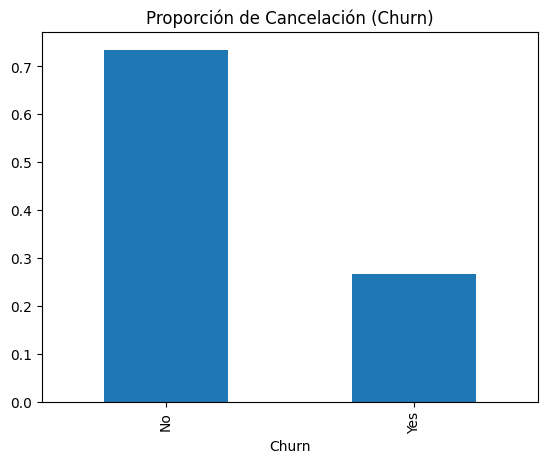

In [5]:


churn_counts = df['Churn'].value_counts(normalize=True)

print('Proporción de cancelación (Churn):')

print(churn_counts)



churn_counts.plot(kind='bar', title='Proporción de Cancelación (Churn)')

## GridSearch con técnicas de balanceo y validación de Recall

Filas sin etiqueta (se eliminan): 224
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros (CV):
{'model__C': 3.0, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'sampler': RandomUnderSampler(random_state=42)}
Mejor Recall CV: 0.8088

=== Classification Report (TEST) ===
              precision    recall  f1-score   support

           0     0.9071    0.7241    0.8053      1294
           1     0.5096    0.7944    0.6209       467

    accuracy                         0.7428      1761
   macro avg     0.7083    0.7593    0.7131      1761
weighted avg     0.8017    0.7428    0.7564      1761

ROC AUC (TEST): 0.8402


<Figure size 500x400 with 0 Axes>

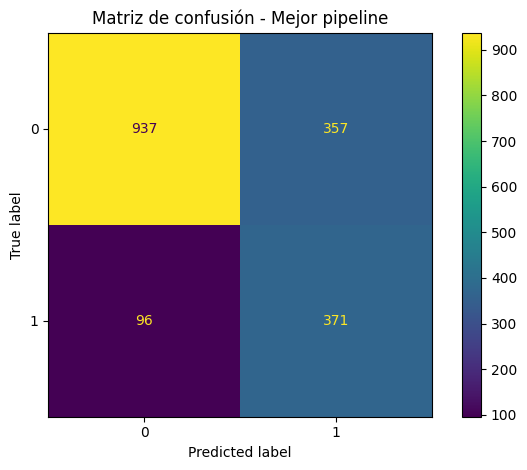


Umbral sugerido para maximizar Recall en TEST: 0.20
Recall=0.9529 | Precision=0.3931 | F1=0.5566


In [7]:

# Limpieza defensiva de infinitos 
df = df.replace([np.inf, -np.inf], np.nan)

# Definición de variables 
TARGET_TXT = "Churn"
DROP_COLS = ["customerID", "Churn", "Churn_numeric"]  # quitamos identificador y duplicados

# Construir y filtrar target
y = df[TARGET_TXT].map({"No": 0, "Yes": 1})
mask_valid = y.notna()
print(f"Filas sin etiqueta (se eliminan): {(~mask_valid).sum()}")

df = df.loc[mask_valid].copy()
y = y.loc[mask_valid].astype(int)

# Features finales
X = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")


# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# Preprocesamiento
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

num_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pre, num_cols),
        ("cat", cat_pre, cat_cols),
    ],
    remainder="drop"
)

# Modelo base
base_clf = LogisticRegression(max_iter=2000)


# Pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("sampler", "passthrough"),      # se reemplaza en la grid
    ("model", base_clf)
])


# Estrategias de balanceo + hiperparámetros del modelo
param_grid = [
    # --- SMOTE ---
    {
        "sampler": [SMOTE(random_state=42, k_neighbors=k) for k in [3, 5]],
        "model__C": [0.3, 1.0, 3.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],   # bueno para l2
        "model__class_weight": [None] # sin class_weight cuando ya muestreamos
    },
    # --- Oversampling aleatorio ---
    {
        "sampler": [RandomOverSampler(random_state=42)],
        "model__C": [0.3, 1.0, 3.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__class_weight": [None]
    },
    # --- Undersampling aleatorio ---
    {
        "sampler": [RandomUnderSampler(random_state=42)],
        "model__C": [0.3, 1.0, 3.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__class_weight": [None]
    },
    # --- Baseline sin muestreo pero con class_weight ---
    {
        "sampler": ["passthrough"],
        "model__C": [0.3, 1.0, 3.0],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__class_weight": ["balanced", None]  # probamos ambos
    },
]


# GridSearchCV optimizando RECALL
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="recall",        # <--- objetivo
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid.fit(X_train, y_train)

print("Mejores parámetros (CV):")
print(grid.best_params_)
print(f"Mejor Recall CV: {grid.best_score_:.4f}")

best_pipe = grid.best_estimator_


# Evaluación en TEST
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC (TEST): {roc_auc_score(y_test, y_proba):.4f}")

plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusión - Mejor pipeline")
plt.tight_layout()
plt.show()


# Ajuste de umbral 
best_threshold = 0.5  # por defecto
candidatos = np.linspace(0.2, 0.6, 9)  # explora umbrales
from sklearn.metrics import recall_score, precision_score, f1_score

mejor_recall = -1
mejor_tuple = None
for thr in candidatos:
    y_hat = (y_proba >= thr).astype(int)
    r = recall_score(y_test, y_hat)
    if r > mejor_recall:
        mejor_recall = r
        mejor_tuple = (thr, r, precision_score(y_test, y_hat), f1_score(y_test, y_hat))
best_threshold = mejor_tuple[0]

print(f"\nUmbral sugerido para maximizar Recall en TEST: {best_threshold:.2f}")
print(f"Recall={mejor_tuple[1]:.4f} | Precision={mejor_tuple[2]:.4f} | F1={mejor_tuple[3]:.4f}")
